# Make fake flat, LFC, and science exposure

In [1]:
import numpy as np
import pylab as plt
from math import inf as infinity
%matplotlib inline

In [2]:
# Set defaults.
specvar = 5. # pixels ** 2
rng = np.random.default_rng(17)
TWOPI = 2. * np.pi
ONEOVERTWOPI = 1. / TWOPI

In [3]:
# Define useful functions.
def gaussian_2d(xxs, yys, mean, var):
    """
    `xxs`   should be shape `(nx, ny)`.
    `yys`   should be shape `(nx, ny)`.
    `mean`  should be shape `(2, )`.
    `var`   should be a scalar.
    """
    return ONEOVERTWOPI / var \
           * np.exp(-0.5 / var * ((xxs - mean[0]) ** 2 + (yys - mean[1]) ** 2))
def gaussian_1d(xxs, mean, var):
    """
    `xxs`   should be shape `(nx, )`.
    `mean`  should be a scalar.
    `var`   should be a scalar.
    """
    return np.sqrt(ONEOVERTWOPI / var) \
           * np.exp(-0.5 / var * (xxs - mean) ** 2)

In [4]:
# Make true 1D spectrum.
linexs = 2. + np.array([4.1, 20.2, 37.0])
depths = 5. * np.array([0.75, 0.7, 0.1])

In [5]:
# Make a version of the true 1D spectrum for plotting purposes.
xfine = np.arange(0., 45., 0.01)
yfine = np.ones_like(xfine)
for x, d in zip(linexs, depths):
    yfine -= d * gaussian_1d(xfine, x, specvar)

Text(0.5, 0, 'x (pix)')

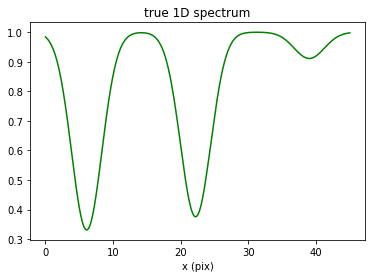

In [6]:
plt.title("true 1D spectrum")
plt.plot(xfine, yfine, 'g-')
plt.xlabel("x (pix)")

In [7]:
# Define trace and the non-orthogonality of the wavelength solution.
def trace(xs):
    return 12.83 - 0.003 * (xs - 50.3) ** 2
def dxdy(xs):
    return - 0.006 * (xs - 50.3)

In [8]:
# Make pixel grids for a tiny image section
xs = np.arange(43).astype(float)
ys = np.arange(21).astype(float)
xxs, yys = np.meshgrid(xs, ys)

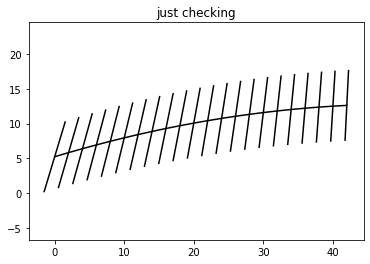

In [9]:
plt.title("just checking")
plt.plot(xs, trace(xs), "k-")
plt.axis("equal")
dy = 5.
for x in np.arange(0, len(xs), 2).astype(float):
    y0 = trace(x)
    plt.plot([x - dxdy(x) * dy, x + dxdy(x) * dy], [y0 - dy, y0 + dy], "k-")


In [10]:
# Make true flat by an agonizing process.
xspots = np.arange(-5., len(xs) + 5., 0.33)
yspots = np.arange(-5., 5., 0.33)
var = 1.0
trueflat = np.zeros_like(xxs).astype(float)
for x in xspots:
    for y in yspots:
        trueflat += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], var)

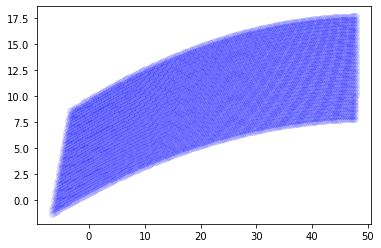

In [11]:
pts = []
for x in xspots:
    for y in yspots:
        pts.append([x + dxdy(x) * y, trace(x) + y])
pts = np.array(pts)
plt.plot(pts[:,0],pts[:,1],'bo',alpha=0.1)
plt.show()

In [12]:
# Make true LFC by a similarly agonizing process.
lfcspots = np.arange(-4., len(xs) + 4., 4 * np.pi)
truelfc = np.zeros_like(xxs).astype(float)
for x in lfcspots:
    for y in yspots:
        truelfc += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], specvar)

In [13]:
#Constructing fitter
def designfit(x_array,y_array,sigma_array,*design):
    N = len(design) #number of variational parameters
    
    #Creating (transposed) design matrix
    A = [model(x_array) for model in design]
    
    #Creating the NxN M_x coefficient matrix
    M_x = np.array([[np.sum(A[i]*sigma_array**(-2)*A[j]) for j in range(N)] for i in range(N)])
    
    #Creating the Nx1 M_y ordinate vector
    M_y = np.array([np.sum(A[i]*sigma_array**(-2)*y_array) for i in range(N)])
    
    #Solving for fit parameters. 
    return (np.linalg.solve(M_x,M_y))

In [14]:
constant1 = lambda x : 1
identity = lambda x : x
square = lambda x : x**2

Text(0, 0.5, '$y$ (pix)')

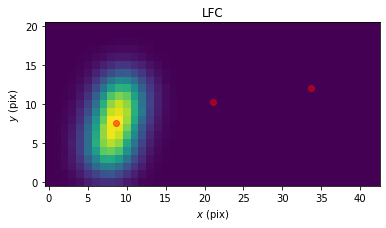

In [15]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}

# Creating LFC for a single spot
lfcspots = np.arange(-4., len(xs) + 4., 4 * np.pi)
truelfc = np.zeros_like(xxs).astype(float)
x = lfcspots[1]
for y in yspots:
    truelfc += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], specvar)
lfc  = truelfc  + 0.01 * np.sqrt(truelfc)  * rng.normal(size=xxs.shape)

plt.title("LFC")
plt.imshow(lfc, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

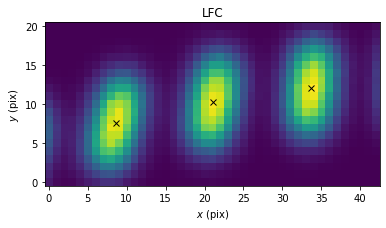

In [90]:
# Creating LFC for a single spot
lfcspots = np.arange(-4., len(xs) + 4., 4 * np.pi)
truelfc = np.zeros_like(xxs).astype(float)
for x in lfcspots:
    for y in yspots:
        truelfc += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], specvar)
lfc  = truelfc  + 0.01 * np.sqrt(truelfc)  * rng.normal(size=xxs.shape)

plt.title("LFC")
plt.imshow(lfc, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "x", alpha=1, color='black')
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")
plt.show()

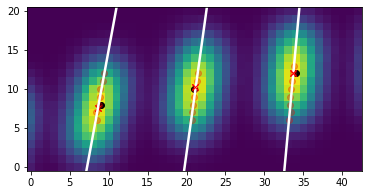

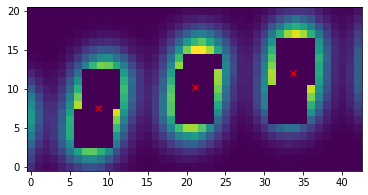

In [94]:
lfc_editable = np.copy(lfc)
max_spot_vals = np.array([np.max(lfc_editable)])

while True:
    #Searching for highest light blob peak
    max_spot_intensity = np.max(lfc_editable)   
    if max_spot_intensity < np.average(max_spot_vals)*0.95:
        break
    max_spot = np.where(lfc_editable==max_spot_intensity)
    max_spot_vals = np.append(max_spot_vals,max_spot_intensity) #Storing value
    current_x, current_y = max_spot[1][0], max_spot[0][0]
    
    #Getting x-pixel indices of max spots per y row
    'The range in y is within 1 "blob sigma".'
    x_max_indices = np.array([current_x])

    ##Downtown
    prev_delta_intensity = 0

    while True:
        delta_intensity = -lfc_editable[current_y,current_x]
        subset_x_index = np.where(lfc_editable[current_y-1,current_x-1:current_x+2]==np.max(lfc_editable[current_y-1,current_x-1:current_x+2]))[0][0]
        proposal_x, proposal_y = current_x+subset_x_index-1, current_y-1
        delta_intensity += lfc_editable[proposal_y,proposal_x]
        if delta_intensity > prev_delta_intensity:
            break
        current_x, current_y = current_x+subset_x_index-1, current_y-1
        x_max_indices = np.insert(x_max_indices,0,current_x)
        prev_delta_intensity = delta_intensity
    y_lower_end = current_y

    ##Uptown
    prev_delta_intensity = 0
    current_x, current_y = max_spot[1][0], max_spot[0][0]
    plt.imshow(lfc,**imshowkwargs)
    plt.plot(current_x,current_y,'o',alpha=1,color='black')
    plt.plot(lfcspots, trace(lfcspots), "x", alpha=1, color='red')

    while True:
        delta_intensity = -lfc_editable[current_y,current_x]
        subset_x_index = np.where(lfc_editable[current_y+1,current_x-1:current_x+2]==np.max(lfc_editable[current_y+1,current_x-1:current_x+2]))[0][0]
        proposal_x, proposal_y = current_x+subset_x_index-1, current_y+1
        delta_intensity += lfc_editable[proposal_y,proposal_x]
        if delta_intensity > prev_delta_intensity:
            break
        current_x, current_y = current_x+subset_x_index-1, current_y+1
        x_max_indices = np.append(x_max_indices,current_x)
        prev_delta_intensity = delta_intensity
    y_upper_end = current_y

    #Solving x-maxima more accurately
    x_max_accurate = np.array([])
    y_max = np.arange(y_lower_end,y_upper_end+1)

    for row_index in range(y_lower_end,y_upper_end+1):
        index = x_max_indices[row_index-y_lower_end]
        parabola_pars = designfit(np.array([index-1,index,index+1]),lfc[row_index,index-1:index+2],np.ones(3),constant1,identity,square)
        x_max_accurate = np.append(x_max_accurate, -parabola_pars[1]/(2*parabola_pars[2]))

    #Getting line fit of x-maxima
    line_radius = 5 #in pixels
    line_pars = designfit(x_max_accurate,y_max,np.ones_like(x_max_accurate),constant1,identity)
    x_line_pts = np.array([max_spot[1]-line_radius,max_spot[1]+line_radius])

    plt.plot(x_max_accurate,y_max,'ro',alpha=0.3)
    plt.plot(x_line_pts,line_pars[0]+line_pars[1]*x_line_pts,color='white',linewidth=2.5)
    
#     #Masking current blob
#     for x in range(max(0,min(x_max_accurate.astype(int))-1),min(len(lfc_editable[0]),max(x_max_accurate.astype(int))+2)):
#         for y in range(max(0,y_lower_end),min(len(lfc_editable),y_upper_end+1)):
#             lfc_editable[y,x] = 0 #Masking analyzed spot 

    #Masking current blob
    mask_width = 2
    
    ##Masking pixels within 1 blob sigma
    for row_index in range(y_lower_end,y_upper_end+1):
        x_max_at_row = x_max_indices[row_index-y_lower_end]
        lfc_editable[row_index,x_max_at_row-mask_width:x_max_at_row+mask_width+1] = 0

    ##Masking pixels further down 1 blob sigma
    edge_threshold = np.exp(-1/2)
    
    ###Uptown
    current_x, current_y = x_max_indices[-1], y_upper_end
    while True:
        max_at_row = np.max(lfc_editable[current_y+1,current_x-1:current_x+2])
        if max_at_row < edge_threshold*max_spot_intensity:
            break
        subset_x_index = np.where(lfc_editable[current_y+1,current_x-1:current_x+2]==max_at_row)[0][0]
        current_x, current_y = current_x+subset_x_index-1, current_y+1
        lfc_editable[current_y,current_x-mask_width:current_x+mask_width+1] = 0

    ###Downtown
    current_x, current_y = x_max_indices[0], y_lower_end
    while True:
        max_at_row = np.max(lfc_editable[current_y-1,current_x-1:current_x+2])
        if max_at_row < edge_threshold*max_spot_intensity:
            break
        subset_x_index = np.where(lfc_editable[current_y-1,current_x-1:current_x+2]==max_at_row)[0][0]
        current_x, current_y = current_x+subset_x_index-1, current_y-1
        lfc_editable[current_y,current_x-mask_width:current_x+mask_width+1] = 0

plt.imshow(lfc,**imshowkwargs)
plt.show()

plt.plot(lfcspots, trace(lfcspots), "x", alpha=1, color='red')
plt.imshow(lfc_editable,**imshowkwargs)
plt.show()

In [71]:
test=np.array([1,2,3,4])
test[2:4]

ahhh


In [70]:
np.where(test[2:4]==3)

(array([0]),)

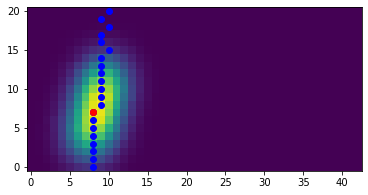

In [495]:
x_max = []
for rows in lfc:
    index = np.where(rows==max(rows))[0][0]
    x_max.append(index)

max_spot = np.where(lfc==np.max(lfc))
plt.plot(max_spot[1],max_spot[0],'ro',alpha=1)
plt.plot(x_max,np.arange(len(x_max)),'bo')
plt.plot(max_spot[1],max_spot[0],'ro',alpha=1)
plt.imshow(lfc,**imshowkwargs)
plt.show()

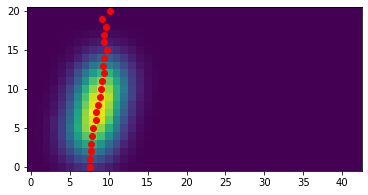

In [496]:
x_max = []
for rows in lfc:
    index = np.where(rows==max(rows))[0][0]
    parabola_pars = designfit(np.array([index-1,index,index+1]),rows[index-1:index+2],np.ones(3),constant1,identity,square)
    x_max.append(-parabola_pars[1]/(2*parabola_pars[2]))
    
    
plt.plot(x_max,np.arange(len(x_max)),'ro')
plt.imshow(lfc,**imshowkwargs)
plt.show()

In [144]:
test = np.arange(10)
test

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.roll

In [188]:
# for rows in lfc:
#     plt.plot(rows-np.roll(rows,-1),'bo')
#     plt.show()

In [77]:
# Make true science image by multiplying the flat.
foo = np.ones_like(xxs)
for x, d in zip(linexs, depths):
    foo -= d * gaussian_1d(xxs - dxdy(xxs) * (yys - trace(xxs)), x, specvar)
truesci = trueflat * foo

In [78]:
np.shape(foo)

(21, 43)

In [79]:
# Make observed images by noisifying the true images.
flat = trueflat + 0.04 * np.sqrt(trueflat) * rng.normal(size=xxs.shape)
lfc  = truelfc  + 0.01 * np.sqrt(truelfc)  * rng.normal(size=xxs.shape)
sci  = truesci  + 0.05 * np.sqrt(truesci)  * rng.normal(size=xxs.shape)

Text(0, 0.5, '$y$ (pix)')

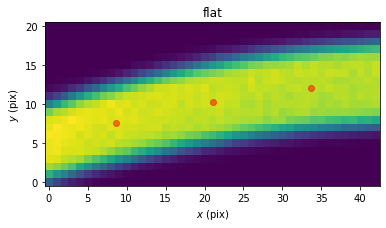

In [80]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
plt.title("flat")
plt.imshow(flat,**imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

Text(0, 0.5, '$y$ (pix)')

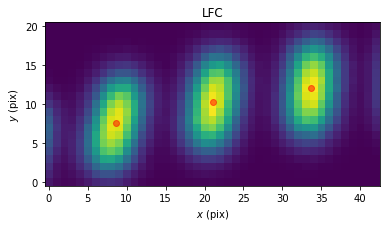

In [81]:
plt.title("LFC")
plt.imshow(lfc, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

Text(0, 0.5, '$y$ (pix)')

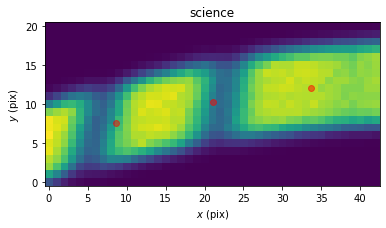

In [82]:
plt.title("science")
plt.imshow(sci, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

In [22]:
# Flat-relative optimal extraction is ONE LINE OF numpy.

def froe(science, flat):
    return np.sum(science * flat, axis=0) / np.sum(flat * flat, axis=0)

In [23]:
# Run FROE to extract the spectrum.
froe_output = froe(sci, flat)
froe_model = flat * froe_output[None, :]

Text(0, 0.5, '$y$ (pix)')

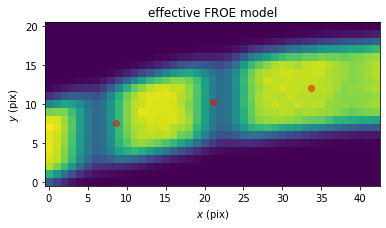

In [24]:
plt.title("effective FROE model")
plt.imshow(froe_model, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

Text(0.5, 0, '$x$ (pix)')

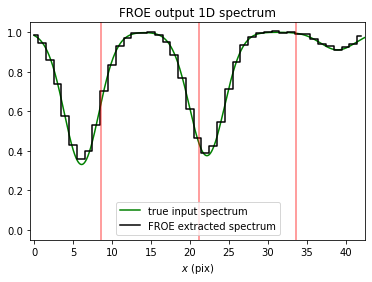

In [20]:
plt.title("FROE output 1D spectrum")
plt.plot(xfine, yfine, 'g-', label="true input spectrum")
plt.step(xs, froe_output, where="mid", color="k", label="FROE extracted spectrum")
#plt.plot(xs, froe_output, "k-", label="FROE extracted spectrum")
for x in lfcspots:
    plt.axvline(x, color="red", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.ylim(-0.05, 1.05)
plt.legend()
plt.xlabel(r"$x$ (pix)")

In [21]:
# Now, just for fun, run FROE to extract the 1D LFC.
lfc_froe_output = froe(lfc, flat)

Text(0.5, 0, '$x$ (pix)')

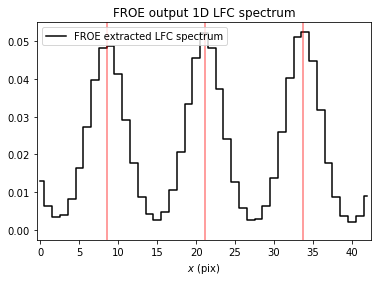

In [22]:
plt.title("FROE output 1D LFC spectrum")
plt.step(xs, lfc_froe_output, where="mid", color="k", label="FROE extracted LFC spectrum")
for x in lfcspots:
    plt.axvline(x, color="red", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
foo = np.max(lfc_froe_output)
plt.ylim(-0.05 * foo, 1.05 * foo)
plt.legend()
plt.xlabel(r"$x$ (pix)")

In [23]:
from scipy.interpolate import BSpline

In [24]:
b = BSpline.basis_element([-2, -1, 0, 1, 2], extrapolate=False)
k = b.k
print(b.t[k:-k])
np.array([ 0.,  1.,  2.,  3.,  4.])
k

[-2. -1.  0.  1.  2.]


3

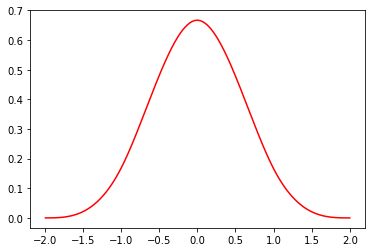

In [25]:
xp = np.arange(-5., 5.001, 0.01)
plt.plot(xp, b(xp), "r-")

In [84]:
xvals = np.array([1,2,3])
yvals = np.array([1,2,3,4])
np.meshgrid(xvals,yvals)

[array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]),
 array([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4]])]